##Program 2
1. Implement a denoising autoencoder that removes noise from images.
2. Train using dataset with artificially added noise.
3. Compare noisy and reconstructed images.

Epoch 1/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 620ms/step - accuracy: 0.0280 - loss: 4.2716 - val_accuracy: 0.0305 - val_loss: 3.6862 - learning_rate: 0.0010
Epoch 2/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 564ms/step - accuracy: 0.0272 - loss: 3.9709 - val_accuracy: 0.0273 - val_loss: 3.7334 - learning_rate: 0.0010
Epoch 3/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 548ms/step - accuracy: 0.0267 - loss: 3.8578 - val_accuracy: 0.0243 - val_loss: 3.6461 - learning_rate: 0.0010
Epoch 4/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 560ms/step - accuracy: 0.0274 - loss: 3.8247 - val_accuracy: 0.0283 - val_loss: 3.6279 - learning_rate: 0.0010
Epoch 5/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 642ms/step - accuracy: 0.0237 - loss: 3.7674 - val_accuracy: 0.0281 - val_loss: 3.6350 - learning_rate: 0.0010
Epoch 6/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 611ms/step - accuracy: 0.0300 - loss: 3.7639 - val_accuracy: 0.0273 - val_loss: 3.6578 - learning_rate: 0.0010
Epoch 7/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 644ms/step - accuracy: 0.0201 - loss: 3.7502 - 

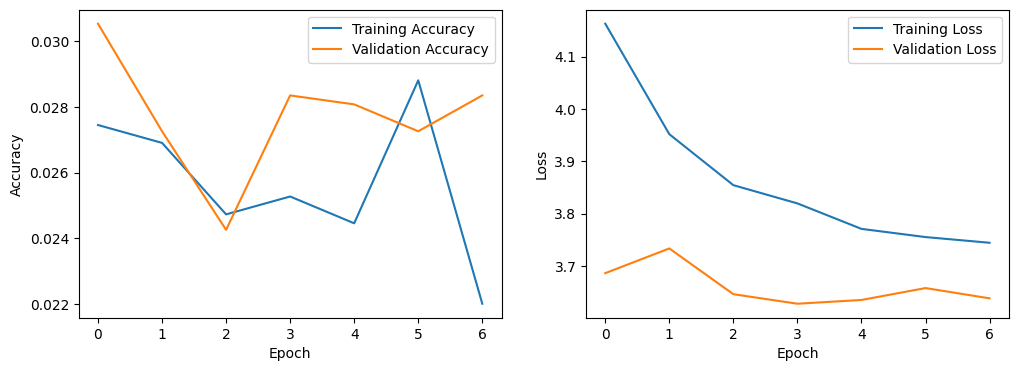

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 904ms/step - loss: 0.0675 - val_loss: 0.0340
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 688ms/step - loss: 0.0277 - val_loss: 0.0220
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 660ms/step - loss: 0.0194 - val_loss: 0.0180
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 654ms/step - loss: 0.0178 - val_loss: 0.0160
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 616ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 682ms/step - loss: 0.0145 - val_loss: 0.0139
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 640ms/step - loss: 0.0128 - val_loss: 0.0138
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - loss: 0.0126 - val_loss: 0.0134
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 653ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 565ms/step - loss: 0.0116 - val_loss: 0.0153
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


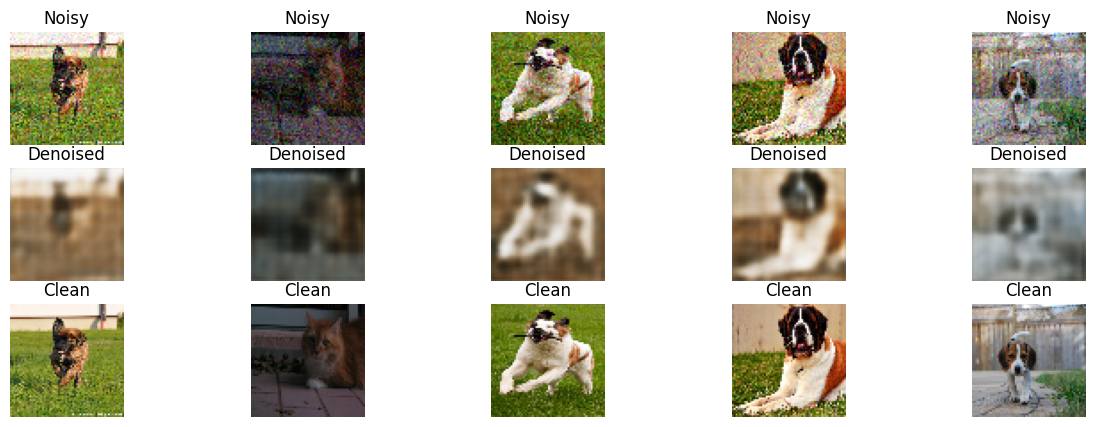

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds  # Import tensorflow_datasets
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np
import os

# Load Oxford IIIT Pets dataset
dataset = tfds.load('oxford_iiit_pet', as_supervised=True)

# Split the dataset into train and validation
train_ds = dataset['train']
val_ds = dataset['test']

# Resize images to a consistent size and normalize
img_size = (64, 64)  # Resize to 64x64 for quicker processing
batch_size = 128

def preprocess(image, label):
    image = tf.image.resize(image, img_size)  # Resize image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize image
    return image, label

train_ds = train_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Add noise to images
def add_noise(image, label):
    noise_factor = 0.1  # Adjust noise level - reduced for better results
    noisy_image = image + noise_factor * tf.random.normal(shape=tf.shape(image))
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)  # Clip to valid range
    return noisy_image, image  # Return noisy image as input, clean image as target

train_ds_noisy = train_ds.map(lambda x, y: add_noise(x, y))
val_ds_noisy = val_ds.map(lambda x, y: add_noise(x, y))

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),  # Reduced rotation for stability
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),  # Reduced contrast
    layers.RandomBrightness(0.1), # Reduced brightness
])

# Build the main model (CNN)
model = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 3)),
    data_augmentation,

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  # Reduced dropout

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Reduced dropout

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),  # Reduced dropout

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(37, activation='softmax')  # 37 classes for Oxford IIIT Pets
])

# Compile the main model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for training
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

# Train the main model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=7,  # Reduced epochs
    callbacks=[early_stopping, lr_scheduler]
)

# Visualize training history for accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Build the Denoising Autoencoder
input_shape = (img_size[0], img_size[1], 3)

encoder = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same')
])

decoder = models.Sequential([
    layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
    layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # Output image
])

autoencoder = models.Sequential([encoder, decoder])

# Compile the Denoising Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Denoising Autoencoder
history_ae = autoencoder.fit(
    train_ds_noisy,
    validation_data=val_ds_noisy,
    epochs=10  # Reduced epochs
)

# Visualize denoising results
def plot_denoised_images(dataset, model, num_images=5):
    for noisy_images, clean_images in dataset.take(1):
        denoised_images = model.predict(noisy_images)
        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            # Noisy image
            plt.subplot(3, num_images, i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title("Noisy")
            plt.axis("off")

            # Denoised image
            plt.subplot(3, num_images, i + num_images + 1)
            plt.imshow(denoised_images[i])
            plt.title("Denoised")
            plt.axis("off")

            # Clean image
            plt.subplot(3, num_images, i + 2 * num_images + 1)
            plt.imshow(clean_images[i].numpy())
            plt.title("Clean")
            plt.axis("off")
        plt.show()

# Plot denoised images
plot_denoised_images(val_ds_noisy, autoencoder)


In [13]:
# Inside the training loop or after predicting denoised images
reconstruction_loss = autoencoder.evaluate(val_ds_noisy)  # This will evaluate the loss on the validation set
print(f"Reconstruction Loss: {reconstruction_loss}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - loss: 0.0154
Reconstruction Loss: 0.015325136482715607


In [6]:
pip install tensorflow-datasets

##Program 3

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - kl_loss: 6.4123 - loss: 345.7755 - reconstruction_loss: 339.3633 - val_kl_loss: 5.9570 - val_loss: 281.1161 - val_reconstruction_loss: 275.1591
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 5.9675 - loss: 278.2293 - reconstruction_loss: 272.2619 - val_kl_loss: 6.1873 - val_loss: 273.4275 - val_reconstruction_loss: 267.2402
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 6.0635 - loss: 270.8906 - reconstruction_loss: 264.8271 - val_kl_loss: 6.1874 - val_loss: 268.8203 - val_reconstruction_loss: 262.6329
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 6.1529 - loss: 267.3026 - reconstruction_loss: 261.1497 - val_kl_loss: 6.0008 - val_loss: 266.3831 - val_reconstruction_loss: 260.3824
Epoch 5/30
469/469

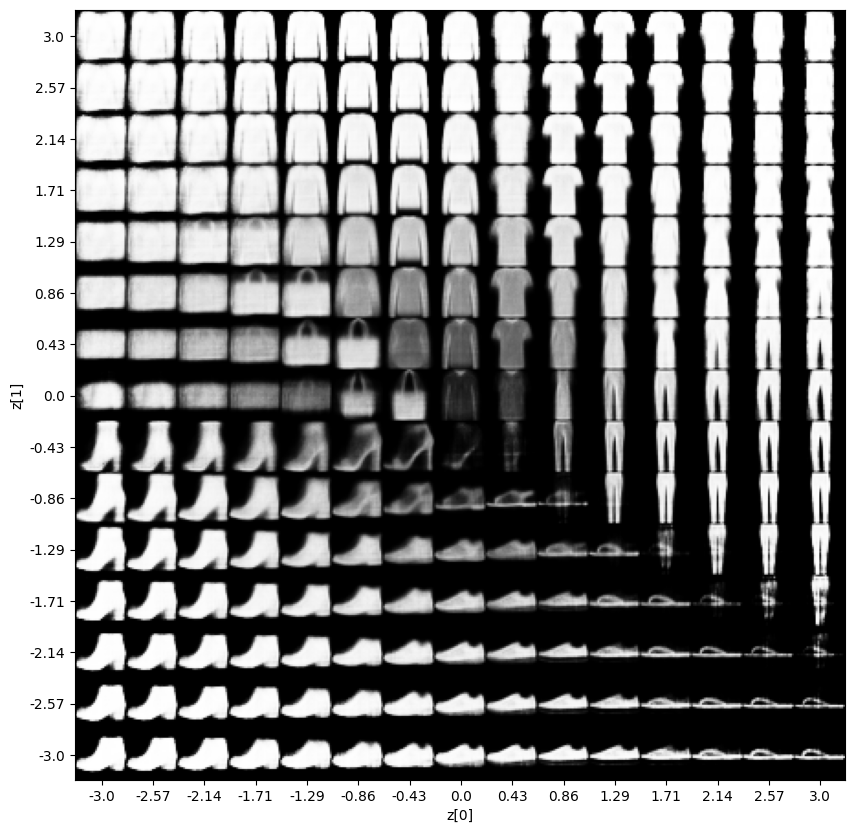

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


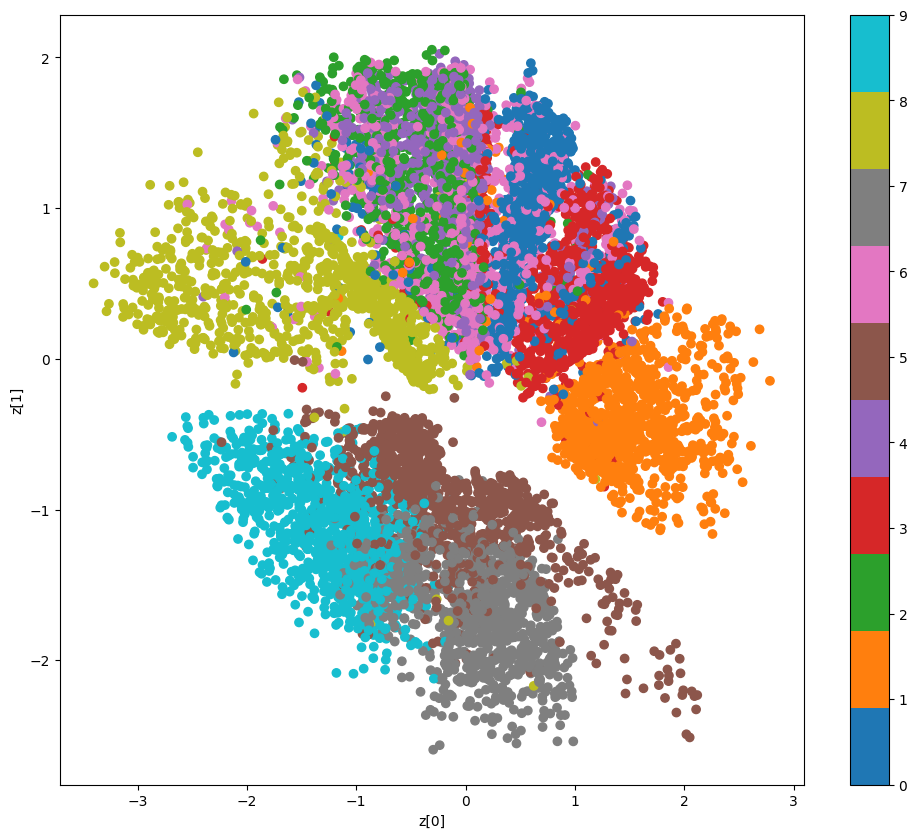

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize and flatten the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((-1, 28 * 28))
x_test = x_test.reshape((-1, 28 * 28))

# Define the Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build the Encoder
latent_dim = 2

encoder_inputs = keras.Input(shape=(784,))
x = layers.Dense(256, activation='relu')(encoder_inputs)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Build the Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(256, activation='relu')(x)
decoder_outputs = layers.Dense(784, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Define the VAE Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        # Return all outputs for potential use in inference
        return reconstruction, z_mean, z_log_var, z

    def train_step(self, data):
        inputs, _ = data  # Ignore targets since they are same as inputs
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(inputs)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(inputs, reconstruction)
            )
            reconstruction_loss *= 784  # Scale by image dimensions
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        inputs, _ = data
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(inputs, reconstruction)
        )
        reconstruction_loss *= 784  # Scale by image dimensions
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

# Train the VAE
vae.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test))

# Generate New Images
n = 15  # Grid size
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
plt.xticks(pixel_range, np.round(grid_x, 2))
plt.yticks(pixel_range, np.round(grid_y, 2))
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.savefig('vae_generated_images.png')  # Save the figure
plt.show()

# Visualize the Latent Space
z_mean, _, _ = encoder.predict(x_test)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.savefig('vae_latent_space.png')  # Save the figure
plt.show()